# Model Building

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load the cleaned and normalized dataset
df_weather = pd.read_csv('../data/cleaned_normalized_weather.csv')


# Convert to datetime
df_weather['last_updated'] = pd.to_datetime(df_weather['last_updated'])

# Sort by time 
df_weather = df_weather.sort_values('last_updated').reset_index(drop=True)


In [4]:
df_weather['year'] = df_weather['last_updated'].dt.year
df_weather['month'] = df_weather['last_updated'].dt.month
df_weather['day'] = df_weather['last_updated'].dt.day
df_weather['hour'] = df_weather['last_updated'].dt.hour
df_weather['dayofweek'] = df_weather['last_updated'].dt.dayofweek


In [5]:
target = 'temperature_celsius'
features = ['month', 'day', 'hour', 'humidity', 'wind_kph', 'pressure_mb', 
            'precip_mm', 'feels_like_celsius', 'visibility_km', 'uv_index']

X = df_weather[features]
y = df_weather[target]

split_index = int(len(df_weather) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## Build Forecasting Models

* Linear Regression 

* Random Forest 

In [6]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [7]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n {model_name} Performance:")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")
    return mae, rmse, r2

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")



 Linear Regression Performance:
MAE:  0.022
RMSE: 0.029
R²:   0.964

 Random Forest Performance:
MAE:  0.008
RMSE: 0.014
R²:   0.991


(0.007575617086858137, np.float64(0.014047328778740506), 0.9913463429497221)

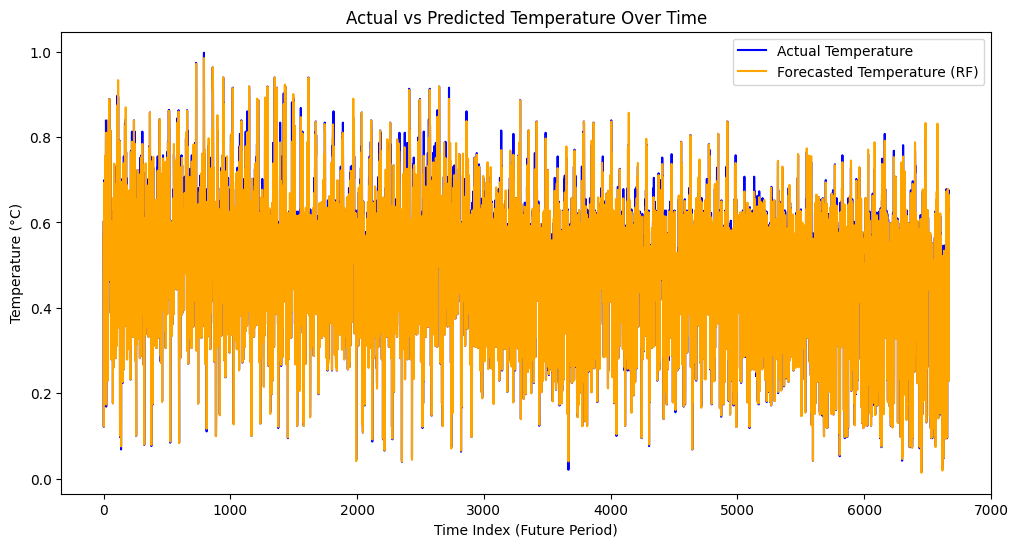

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Temperature', color='blue')
plt.plot(y_pred_rf, label='Forecasted Temperature (RF)', color='orange')
plt.title('Actual vs Predicted Temperature Over Time')
plt.xlabel('Time Index (Future Period)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


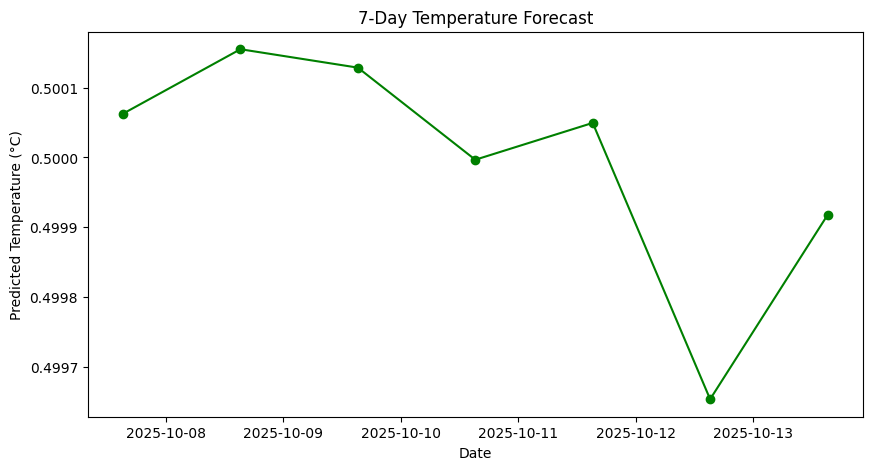

In [9]:
# Future Forecasting
future_dates = pd.date_range(start=df_weather['last_updated'].max(), periods=8, freq='D')[1:]
future_df = pd.DataFrame({'last_updated': future_dates})
future_df['month'] = future_df['last_updated'].dt.month
future_df['day'] = future_df['last_updated'].dt.day
future_df['hour'] = 12  # Assume midday readings

# Add mean values of other numeric features
for feature in ['humidity', 'wind_kph', 'pressure_mb', 'precip_mm', 'feels_like_celsius', 'visibility_km', 'uv_index']:
    future_df[feature] = df_weather[feature].mean()

future_forecast = rf_model.predict(future_df[features])
plt.figure(figsize=(10,5))
plt.plot(future_dates, future_forecast, marker='o', color='green')
plt.title('7-Day Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (°C)')
plt.show()


## XGBoost

In [10]:
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "XGBoost")



 XGBoost Performance:
MAE:  0.008
RMSE: 0.014
R²:   0.992


(0.007972215912584023, np.float64(0.01383282300866117), 0.9916086115498448)

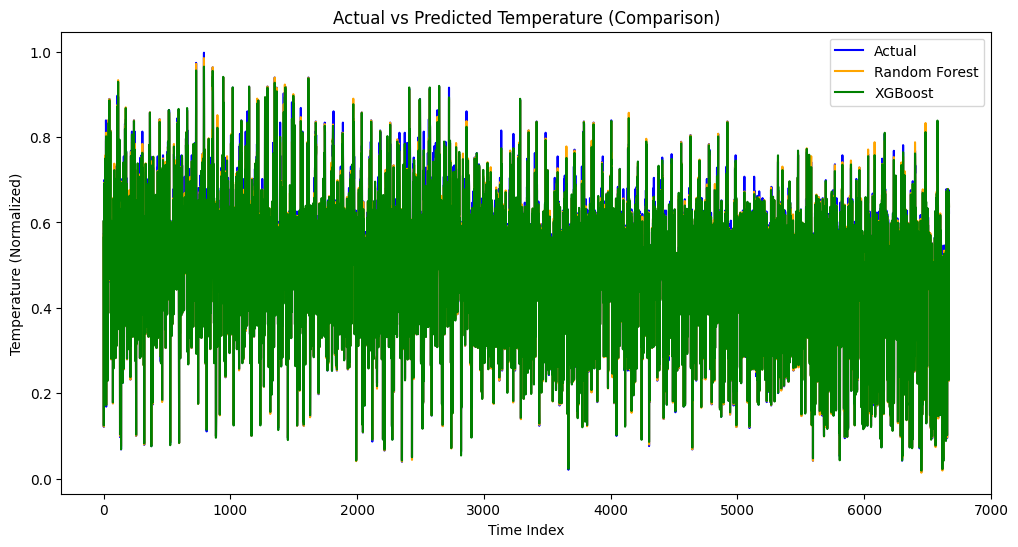

In [11]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rf, label='Random Forest', color='orange')
plt.plot(y_pred_xgb, label='XGBoost', color='green')
plt.title('Actual vs Predicted Temperature (Comparison)')
plt.xlabel('Time Index')
plt.ylabel('Temperature (Normalized)')
plt.legend()
plt.show()


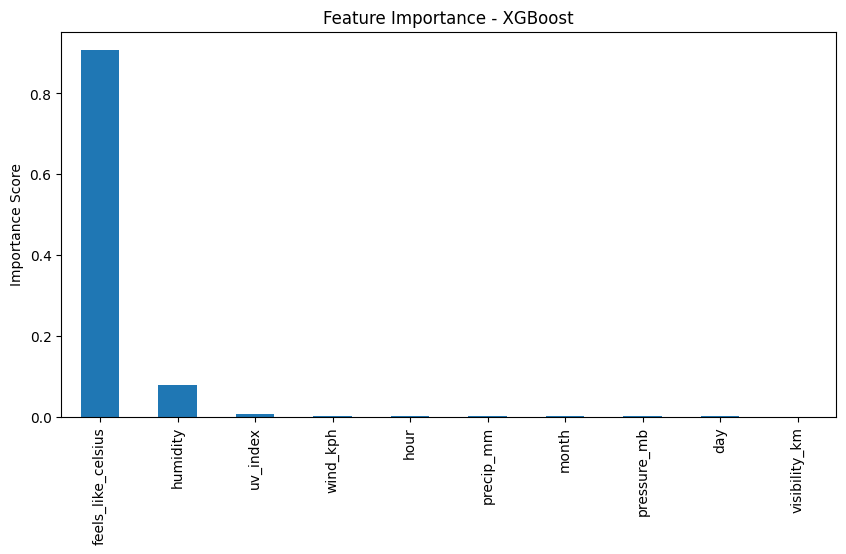

In [12]:

xgb_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', figsize=(10,5), title='Feature Importance - XGBoost')
plt.ylabel('Importance Score')
plt.show()


## Thanks